# Interactive Julia for *A Simple Nearly-optimal Restart Scheme for Speeding-Up First Order Methods* #

### James Renegar, Benjamin Grimmer ###
___

This notebook follows along the ideas presented in [[1]](https://arxiv.org/abs/1803.00151). Its purpose is to give a simple and understandable implementation of the algorithms and concepts therein. Throughout this document, we may reference equations, lemmas, and theorems using the numbering given in that paper. 

The general outline of this document is the following:

1. Implementation of Basic Synchronous Scheme
2. Solving Some Simple Problems:
    * One Norm Minimization via Subgradient Method
    * Regularized Least Squares via Accelerated Method
3. Implementation of Parallel Asynchronous Scheme
4. Solving an Interesting Problems:
    * --- via Inexact Proximal Point Method

**License**: Creative Commons License

This work is licensed under a Creative Commons Attribution-ShareAlike 4.0 International License (http://creativecommons.org/licenses/by-sa/4.0/).

An MIT License for the underlying software is provided in the separate LICENSE file.

**Disclaimer**: We make no claim that the code below is optimized or the most efficient version possible. Instead our goal is to give the simplest implementation possible. Speedups are certainly possible using optimized linear algebra packages and by taking advantage of sparsity and problem specific structure.

Any questions or feedback on this document can be sent to Ben Grimmer at *bdg79@cornell.edu*. 

[1] "A Simple Nearly-Optimal Restart Scheme For Speeding-Up First Order Methods", https://arxiv.org/abs/1803.00151. James Renegar, Benjamin Grimmer. First posted March 1st, 2018.

In [1]:
#Importing plotting package to be used
using PyPlot

#Launching 16 threads for parallel algorithm to eventually use.
#Our code below will all have the macro @everything attached to share the definitions with these threads
processes = addprocs(16);

# Implementation of Basic Synchronous Scheme #

The primary contribution of this paper is proposing a simple scheme for restarting first-order optimization methods (in a way amenable to simple analysis). This scheme can be implemented sequentially or in parallel (and of those synchronously or asynchronously). We begin by defining the simplest sequential, synchronuous scheme here.

We consider an abstract problem and algorithm defined by the following three types:

A **problem instance** must have a field **f** giving an oracle for function evaluation.

An **algorithm state** must have a field **iterate** giving the current solution.

An **algorithm** must provide two functions:
* **initialization(problem_instance, iterate, epsilon)**, which produces an algorithm state.
* **iteration(algorithm_state)**, which updates the given state bby one iteration.

In [2]:
@everywhere abstract type problem_instance end
@everywhere type algorithm
        initialization
        iteration
    end
@everywhere abstract type algorithm_state end;

### The Direct Scheme for Applying an Algorithm ###

Then the naive way to solve a problem instance using a given algorithm is to iterative call **iteration()** a fixed number of times. This is implemented as follows:

In [3]:
function direct_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    #Apply alg to the inst starting from x0 for T iterations
    
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    state = alg.initialization(inst, x0, epsilon)
    
    for i in 1:T 
        alg.iteration(state)
        ret[i+1] = min(ret[i], inst.f(state.iterate))
    end
    return ret, state.iterate
end;

### The Sequential Synchronuous Restarting Scheme for Applying an Algorithm ###

This paper proposes an intelligent restarting scheme for applying an algorithm, which is shown to improve the convergence of many standard first-order methods in the presence of certain problem growth structures (e.g., sharpness or strong convexity).

At a high level, this scheme runs $N=log(1/\epsilon)$ copies of the algorithm in parallel. For each $i=1,..N$, process $i$ targets improvements in objective of $1/2^i$. Whenever its target is reached, it restarts at its current iterate and sends that iterate to process $i+1$ in case it also wants to restart. We implement this scheme below in the simplest setting of sequentially doing one iteration by each process in cyclic fashion.

In [4]:
function synchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)
    ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
    ret[1] = inst.f(x0)
    
    N = max(2,ceil(Int64, -1*log(2,epsilon))) #Compute how many processes to use
    eps = Array{Float64}(N)            #Accuracy level used by each algorithm instance
    states = Array{algorithm_state}(N) #Current state of each parallel algorithm instance
    objs = Array{Float64}(N)           #Target objective value of each algorithm instance
    
    for j in 1:N #Initialization loop
        eps[j] = 2.0^(-1*j)
        states[j] = alg.initialization(inst, x0, eps[j])
        objs[j] = inst.f(x0) - eps[j]
    end

    for i in 1:T
        #Handle first process since its special
        value = inst.f(states[1].iterate)
        if value < objs[2]
            states[2] = alg.initialization(inst, states[1].iterate, eps[2])
            objs[2] = value - eps[2]
        end
        alg.iteration(states[1])
        
        #Handle the middle processes
        for j in 2:(N-1)
            value = inst.f(states[j].iterate)
            if value < objs[j+1]
                states[j+1] = alg.initialization(inst, states[j].iterate, eps[j+1])
                objs[j+1] = value - eps[j+1]
            end
            if value < objs[j]
                states[j] = alg.initialization(inst, states[j].iterate, eps[j])
                objs[j] = value - eps[j]
            end
            alg.iteration(states[j])
        end

        #Handle last process since its special
        value = inst.f(states[N].iterate)
        if value < objs[N]
            states[N] = alg.initialization(inst, states[N].iterate, eps[N])
            objs[N] = value - eps[N]
        end
        alg.iteration(states[N])
        ret[i+1] = min(ret[i], inst.f(states[N].iterate))
    end
    return ret, states[N].iterate
end;

# Solving Some Simple Problems #

Now we turn our attention to experimenting with this scheme on some simple problems. To do so, we need to implement an our abstract types of **problem_instance**, **algorithm_state**, and **algorithm** for some particular first-order method, and then construct a suitable problem instance to apply it on.

### The Subgradient Method ###
 We begin by defining arguably the simplest first-order method, the *Subgradient Method*.

In [5]:
@everywhere type subgradientMethod_instance <: problem_instance
        f
        subgrad_f
    end
@everywhere type subgradientMethod_state <: algorithm_state
        instance::subgradientMethod_instance
        iterate
        epsilon::Float64
    end

@everywhere function subgradientMethod_initialization(inst::subgradientMethod_instance, x0, epsilon::Float64)
        return subgradientMethod_state(inst, x0, epsilon)
    end
@everywhere function subgradientMethod_iteration(state::subgradientMethod_state)
        g = state.instance.subgrad_f(state.iterate)
        if norm(g) > 0.0001
            state.iterate = state.iterate - state.epsilon*g/norm(g)^2
        end
    end

@everywhere subgradientMethod = algorithm(subgradientMethod_initialization, subgradientMethod_iteration);

### A Suitable Problem for the Subgradient Method ###

For any problem where we can give a subgradient oracle, we can immidiately apply the subgradient method directly (via direct_scheme()) or in a parallel fashion (via synchronuous_restarting_scheme()).

Consider minimizing the one norm of a vector
$$ f(x) = \|x\|_1.$$
We define an instance of this simple problem as follows:

In [6]:
@everywhere function oneNorm(x)
    norm(x,1)
end
@everywhere function subgrad_oneNorm(x)
    g = zeros(length(x))
    for i in 1:length(x)
        if x[i]>10.0^-8
            g[i]=1
        elseif x[i]<-10.0^-8
            g[i]=-1
        else
            g[i]=0
        end
    end
    return g
end

@everywhere oneNorm_instance = subgradientMethod_instance(oneNorm, subgrad_oneNorm);

Below apply many iterations of the subgradient method directly and apply many iterations via our restarting scheme. Plotting the result of this simple example shows a very quick linear convergence for our restarting method (as one would expect from Theorem ?? of [[1]](https://arxiv.org/abs/1803.00151)) since the one norm is both Lipschitz and sharp.

In [7]:
history1, final_state1 = direct_scheme(subgradientMethod, oneNorm_instance, [1.07,0.0,-2.1], 0.05, 100);

In [8]:
history2, final_state2 = synchronuous_restarting_scheme(subgradientMethod, oneNorm_instance, [1.07,0.0,-2.1], 0.05, 100);

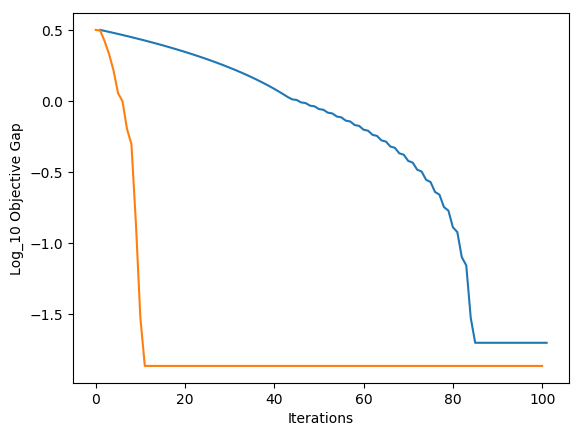

In [9]:
plot(1:101, log.(10, history1), log.(10, history2))
xlabel("Iterations")
ylabel("Log_10 Objective Gap");

### Nesterov's Accelerated Gradient Method ###

For smooth optimization problems, that is minimizing functions with $L$-Lipschitz continuous gradients, one can improve the convergence of the subgradient method (or gradient descent) by using *Nesterov's Accelerated Gradient Method*. Below we implement this assuming this Lipschitz constant is known.

In [10]:
@everywhere type acceleratedMethod_instance <: problem_instance
        f
        grad_f
        L::Float64
    end
@everywhere type acceleratedMethod_state <: algorithm_state
        instance::acceleratedMethod_instance
        prev_iterate
        iterate
        counter::Int64
    end

@everywhere function acceleratedMethod_initialization(inst::acceleratedMethod_instance, x0, epsilon::Float64)
        return acceleratedMethod_state(inst, x0, x0, 0)
    end
@everywhere function acceleratedMethod_iteration(state::acceleratedMethod_state)
        k = state.counter
        x1 = state.iterate
        x0 = state.prev_iterate
        y = x1 + (k+2)/(k+1)*(x1 - x0)
        g = state.instance.grad_f(y)
    
        state.prev_iterate = x1
        state.iterate = y - g/state.instance.L
        state.counter = k+1
    end

@everywhere acceleratedMethod = algorithm(acceleratedMethod_initialization, acceleratedMethod_iteration);

### A Suitable Problem for Nesterov's Accelerated Gradient Method ###

Then for any problem where we can give a gradient oracle and bound the Lipschitz constant of the gradient, we can immidiately apply the accelerated method directly (via direct_scheme()) or in a parallel fashion (via synchronuous_restarting_scheme()).

Consider solving a least squares problem plus a smooth regularizer.
$$ f(x) = \|Ax-b\|_2^2 + \|x\|^4_4.$$
We define an instance of this simple problem as follows (setting $b=0$ so that we know the optimal objective value is zero):

In [11]:
@everywhere A = randn(10,5)
@everywhere b = zeros(10) #randn(10)
@everywhere function leastSquares(x)
    norm(A*x-b)^2 + norm(x,4)^4
end
@everywhere function grad_leastSquares(x)
    return A'*(A*x-b) + 4*x.^3
end
#The lipschitz constant from the regularizer will depend on how close to optimal the method starts. We'll fudge it and say 200.
leastSquares_instance = acceleratedMethod_instance(leastSquares, grad_leastSquares, norm(A)^2+200);

Below apply many iterations of the subgradient method directly and apply many iterations via our restarting scheme. Plotting the result of this test shows the restarting scheme also provides an improvement to the convergence here.

In [12]:
history1, final_state1 = direct_scheme(acceleratedMethod, leastSquares_instance, [1.07,5.0,-2.1,3.0,-0.1], 0.01, 100);

In [13]:
history2, final_state2 = synchronuous_restarting_scheme(acceleratedMethod, leastSquares_instance, [1.07,5.0,-2.1,3.0,-0.1], 0.01, 100);

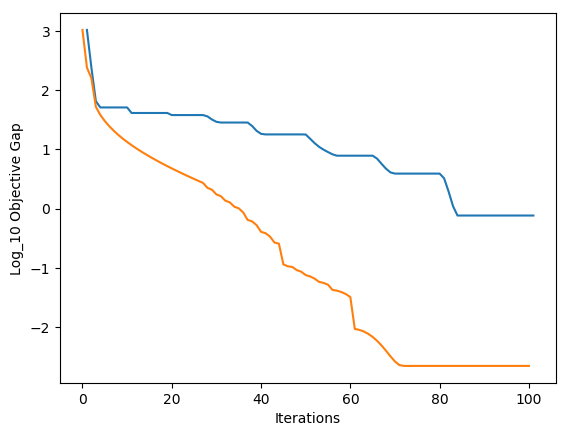

In [14]:
plot(1:101, log.(10, history1), log.(10, history2))
xlabel("Iterations")
ylabel("Log_10 Objective Gap");

# Implementation of Parallel Asynchronous Scheme #

Importantly, the restarting scheme leveraged by this paper can be easily parallelized. Each of the $log(1/\epsilon)$ copies of the algorithm can be run by separate processes. This parallelization does not require any synchonization since they only need to pass messages forward to the following process. Thus an asynchronous parallel version follows without much modification from the sequential version previously given.

In [15]:
function asynchronuous_restarting_scheme(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64)    
    N = min(16, max(2,ceil(Int64, -1*log(2,epsilon))))   #Compute how many processes to use, must be between 2 and 16
    
    @everywhere function first_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64,
                    output::RemoteChannel{Channel{Tuple}})
        ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
        ret[1] = inst.f(x0)
        state = alg.initialization(inst, x0, epsilon)
        obj = inst.f(x0) - epsilon
        for i in 1:T
            alg.iteration(state)
            value = inst.f(state.iterate)
            ret[i+1] = min(ret[i], value)
            if value < obj
                obj = value - epsilon
                put!(output, (state.iterate, value))
            end
        end
        ret, state.iterate
    end
    @everywhere function middle_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64, 
                    input::RemoteChannel{Channel{Tuple}}, output::RemoteChannel{Channel{Tuple}})
        ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
        ret[1] = inst.f(x0)
        
        state = alg.initialization(inst, x0, epsilon)
        obj = inst.f(x0) - epsilon
        for i in 1:T
            alg.iteration(state)
            x, value = state.iterate, inst.f(state.iterate)
            ret[i+1] = min(ret[i], value)
            while isready(input)
                y, v = take!(input)
                if v<value
                    x, value = y,v
                end
            end
            if value < obj
                obj = value - epsilon
                state = alg.initialization(inst, x, epsilon)
                put!(output, (x, value))
            end
        end 
        ret, state.iterate
    end
    @everywhere function last_worker_loop(alg::algorithm, inst::problem_instance, x0, epsilon::Float64, T::Int64, 
                    input::RemoteChannel{Channel{Tuple}})
        ret = Array{Float64}(T+1) #Record of minimum objective value seen at each iteration
        ret[1] = inst.f(x0)
    
        state = alg.initialization(inst, x0, epsilon)
        obj = inst.f(x0) - epsilon
        for i in 1:T
            alg.iteration(state)
        
            x, value = state.iterate, inst.f(state.iterate)
            ret[i+1] = min(ret[i], value)
            while isready(input)
                y, v = take!(input)
                if v<value
                    x, value = y,v
                end
            end
            if value < obj
                obj = value - epsilon
                state = alg.initialization(inst, x, epsilon)
            end
        end
        return ret, state.iterate
    end
    
    inputs = Array{RemoteChannel{Channel{Tuple}}}(N-1)
    for j in 1:(N-1)
        inputs[j] = RemoteChannel(()->Channel{Tuple}(32));
    end
    #Assigning each thread its task
    ret = Array{Array{Float64}}(N)
    x = Array{Array{Float64}}(N)
    futures = Array{Future}(N)
    for j in 1:N
        p = processes[j]
        if j==1
            #Launch first process
            futures[j] = remotecall(first_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j])
        elseif j<N
            #Launch middle processes
            futures[j] = remotecall(middle_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j-1], inputs[j])
        else
            #Launch last process
            futures[j] = remotecall(last_worker_loop, p, alg, inst, x0, 2.0^(-1*j), T, inputs[j-1])
        end
    end
    for j in 1:N
        ret[j], x[j] = fetch(futures[j])
    end
    return ret, x
end;

### Resolving The Two Previous Problems in Parallel Asynchonously ###

Since we already have constructed toy problem instances suitable for the subgradient method and the accelerated method, we begin by applying the parallel sheme to them.

The result from applying this method is the sequence of minimum objective values seen by each process. We plot this for the seven threads employed on each problem. *Importanly, these plots do not show wallclock time, but rather the objevtive of each process when it was on a given iteration number.*

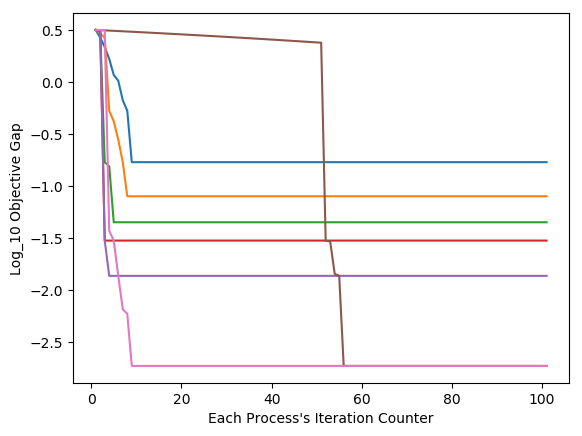

In [19]:
ret, x = asynchronuous_restarting_scheme(subgradientMethod, oneNorm_instance, [1.07,0.0,-2.1], 0.01, 100)

for i in 1:length(ret)
    plot(1:101, log.(10, ret[i]))
end
xlabel("Each Process's Iteration Counter")
ylabel("Log_10 Objective Gap");

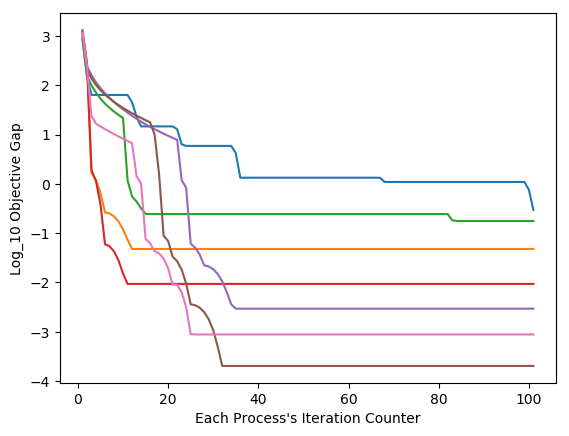

In [20]:
ret, x = asynchronuous_restarting_scheme(acceleratedMethod, leastSquares_instance, [1.07,5.0,-2.1,3.0,-0.1], 0.01, 100)

for i in 1:length(ret)
    plot(1:101, log.(10, ret[i]))
end
xlabel("Each Process's Iteration Counter")
ylabel("Log_10 Objective Gap");

# Solving an Interesting Problem #

For the subgradient method and accelerated method, each iteration often takes approximately the same amount of time. As a result, there may not be much gained from allowing the threads to run asynchonuously. However, for algorithms with variable iteration cost this becomes an important feature.

For example, 